# Tip Inventory Consolidation

In [1]:
script_mode = 'simulation'

In [2]:
import numpy as np
import random
import timeit

In [3]:
from typing import List, Any, Generator

In [4]:
def divide_list_into_chunks(
        list_l: List[Any],
        chunk_size: int
    ) -> Generator[List[Any], None, None]:
    """
    Divides a list into smaller chunks of a specified size.

    Parameters:
    - list_l (List[Any]): The list to be divided into chunks.
    - chunk_size (int): The size of each chunk.

    Returns:
    - Generator[List[Any], None, None]: A generator that yields chunks of the list.
    """
    for i in range(0, len(list_l), chunk_size):
        yield list_l[i:i + chunk_size]

## Workcell Setup

In [5]:
%load_ext autoreload
%autoreload 2

from pylabrobot.liquid_handling import LiquidHandler
from pylabrobot.resources.hamilton import STARLetDeck
import logging
from pylabrobot.visualizer.visualizer import Visualizer

if script_mode == 'execution':
    from pylabrobot.liquid_handling.backends import STARBackend
    backend = STARBackend()
elif script_mode == 'simulation':
    # from pylabrobot.liquid_handling.backends.simulation.simulator_backend import SimulatorBackend
    from pylabrobot.liquid_handling.backends import LiquidHandlerChatterboxBackend
    backend = LiquidHandlerChatterboxBackend()

logger = logging.getLogger("pylabrobot")
logger.setLevel(logging.DEBUG) # <-- choose a level

In [6]:
lh = LiquidHandler(backend=backend, deck=STARLetDeck())

await lh.setup()
vis = Visualizer(resource=lh)
await vis.setup()
if script_mode == 'simulation':
    from pylabrobot.resources import set_tip_tracking, set_volume_tracking
    set_tip_tracking(True), set_volume_tracking(False);
else:
    await lh.backend.disable_cover_control()
    await lh.backend.move_all_channels_in_z_safety()
    lh.backend.allow_firmware_planning = True # very powerful
    lh.backend.read_timeout = 240 # give your commands more time

Setting up the liquid handler.
Resource deck was assigned to the liquid handler.
Resource trash was assigned to the liquid handler.
Resource trash_core96 was assigned to the liquid handler.
Resource teaching_carrier was assigned to the liquid handler.
Websocket server started at http://127.0.0.1:2121
File server started at http://127.0.0.1:1337 . Open this URL in your browser.


## Deck Setup

In [7]:
from pylabrobot.resources import (
    TIP_CAR_480_A00, PLT_CAR_L5AC_A00, # TIP & PLATE CARRIERS
    MFX_CAR_L4_SHAKER,
    HTF, STF, TIP_50ul, # TIPS
    Coordinate
)

In [8]:
import numpy as np

In [9]:
tip_carrier = TIP_CAR_480_A00(name="tip carrier") # initialize a tip carrier

tip_carrier[2] = tip_rack_1000ul_3 = HTF(name="tip_rack_1000ul_3", with_tips=False)
tip_carrier[1] = tip_rack_1000ul_2 = HTF(name="tip_rack_1000ul_2")
tip_carrier[0] = tip_rack_1000ul_1 = HTF(name="tip_rack_1000ul_1")

lh.deck.assign_child_resource(tip_carrier, rails=15)

Resource tip carrier was assigned to the liquid handler.


In [10]:
tip_carrier_2 = TIP_CAR_480_A00(name="tip carrier 2") # initialize a tip carrier

tip_carrier_2[2] = tip_rack_50ul_3 = TIP_50ul(name="tip_rack_50ul_3", with_tips=False)
tip_carrier_2[1] = tip_rack_50ul_2 = TIP_50ul(name="tip_rack_50ul_2")
tip_carrier_2[0] = tip_rack_50ul_1 = TIP_50ul(name="tip_rack_50ul_1")

lh.deck.assign_child_resource(tip_carrier_2, rails=22)

Resource tip carrier 2 was assigned to the liquid handler.


In [11]:
np.set_printoptions(linewidth=120)  # increase line width


In [12]:
n = 40
numbers = random.sample(range(96), k=n)

_ = [tip_rack_1000ul_1.children[idx].tracker.remove_tip() for idx in numbers]

In [13]:
n = 20
numbers = random.sample(range(96), k=n)

_ = [tip_rack_1000ul_2.children[idx].tracker.remove_tip() for idx in numbers]

In [14]:
n = 55
numbers = random.sample(range(96), k=n)

_ = [tip_rack_50ul_1.children[idx].tracker.remove_tip() for idx in numbers]

In [15]:
lh.summary()

Rail  Resource                      Type           Coordinates (mm)
(-6)  ├── trash_core96              Trash          (-58.200, 106.000, 229.000)
      │
(15)  ├── tip carrier               TipCarrier     (415.000, 063.000, 100.000)
      │   ├── tip_rack_1000ul_1     TipRack        (421.200, 073.000, 214.950)
      │   ├── tip_rack_1000ul_2     TipRack        (421.200, 169.000, 214.950)
      │   ├── tip_rack_1000ul_3     TipRack        (421.200, 265.000, 214.950)
      │   ├── <empty>
      │   ├── <empty>
      │
(22)  ├── tip carrier 2             TipCarrier     (572.500, 063.000, 100.000)
      │   ├── tip_rack_50ul_1       TipRack        (578.700, 073.000, 214.950)
      │   ├── tip_rack_50ul_2       TipRack        (578.700, 169.000, 214.950)
      │   ├── tip_rack_50ul_3       TipRack        (578.700, 265.000, 214.950)
      │   ├── <empty>
      │   ├── <empty>
      │
(31)  ├── teaching_carrier          Resource       (775.000, 051.800, 100.000)
      │   ├── teaching_tip_rac

In [16]:
import matplotlib.pyplot as plt

In [17]:
# Convert to integer for visualization (True -> 1, False -> 0)

def show_tip_rack(tip_rack):

    def show_real_tiprack_state(tiprack_l):
        tip_rack_arr = np.array(tiprack_l.children, dtype=object).reshape(12,8).T
        
        has_tip_vectorized = np.vectorize(lambda obj: obj.has_tip())
        
        return has_tip_vectorized(tip_rack_arr)
    
    int_array = show_real_tiprack_state(tip_rack).astype(int)
    
    # Display using imshow
    plt.imshow(int_array, cmap="gray_r")  # gray_r: black=1, white=0
    plt.title("Boolean Array Visualization")
    plt.colorbar(label='Value')
    plt.xticks(range(int_array.shape[1]))
    plt.yticks(range(int_array.shape[0]))
    plt.grid(False)
    plt.show()



## 1- identify tipracks

In [18]:
from pylabrobot.resources import TipRack

all_tipracks_on_deck_list = [
    item for item in lh.get_all_children()
    if all(
        [
            isinstance(item, TipRack),
            item.name != "teaching_tip_rack"
        ]
    )
]

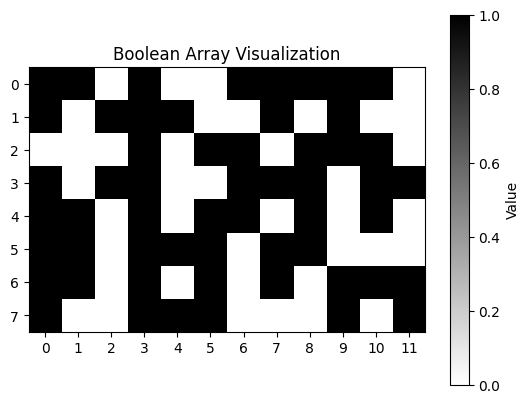

In [19]:
show_tip_rack(all_tipracks_on_deck_list[0])

In [20]:
all_tipracks_on_deck_list[0].summary()

+------------+
|oo o  ooooo |
|o ooo  o o  |
|   o oo ooo |
|o oo  ooo oo|
|oo o oo o o |
|oo ooo oo   |
|oo o o o ooo|
|o  ooo   o o|
+------------+



## 3- sorting algorithm

### 3.1- cluster tipracks by model

### 3.2- store only partially-filled tipracks

### 3.3- sort partially-filled tipracks by minimal fill_len

In [21]:
all_tipracks_on_deck_list

[TipRack(name=tip_rack_1000ul_1, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000)),
 TipRack(name=tip_rack_1000ul_2, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000)),
 TipRack(name=tip_rack_1000ul_3, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000)),
 TipRack(name=tip_rack_50ul_1, size_x=122.4, size_y=82.6, size_z=18.0, location=Coordinate(000.000, 000.000, 000.000)),
 TipRack(name=tip_rack_50ul_2, size_x=122.4, size_y=82.6, size_z=18.0, location=Coordinate(000.000, 000.000, 000.000)),
 TipRack(name=tip_rack_50ul_3, size_x=122.4, size_y=82.6, size_z=18.0, location=Coordinate(000.000, 000.000, 000.000))]

In [27]:
clusters_by_model = {}

for idx, tip_rack in enumerate(all_tipracks_on_deck_list):
    print(idx, tip_rack)

    # Only consider partially-filled tip_racks
    tip_status = [
            tip_spot.tracker.has_tip
            for tip_spot in tip_rack.children
        ]
    partially_filled = any(tip_status) and not all(tip_status)

    if partially_filled:
        
        # Identify model by hashed unique physical characteristics
        current_model = hash(tip_rack.children[0].tracker.get_tip())
        num_empty_tipspots = len([tip for tip in tip_status if tip==False])
        
        sanity_check = all(
            [
                hash(tip_spot.tracker.get_tip())==current_model 
                for tip_spot in tip_rack.children[1:]
            ]
        )
        
        if sanity_check:
            clusters_by_model.setdefault(current_model, []).append((tip_rack, num_empty_tipspots))

# Sort partially-filled tipracks by minimal fill_len
for model, rack_list in clusters_by_model.items():
    rack_list.sort(key=lambda x: x[1])

0 TipRack(name=tip_rack_1000ul_1, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000))
1 TipRack(name=tip_rack_1000ul_2, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000))
2 TipRack(name=tip_rack_1000ul_3, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000))
3 TipRack(name=tip_rack_50ul_1, size_x=122.4, size_y=82.6, size_z=18.0, location=Coordinate(000.000, 000.000, 000.000))
4 TipRack(name=tip_rack_50ul_2, size_x=122.4, size_y=82.6, size_z=18.0, location=Coordinate(000.000, 000.000, 000.000))
5 TipRack(name=tip_rack_50ul_3, size_x=122.4, size_y=82.6, size_z=18.0, location=Coordinate(000.000, 000.000, 000.000))


In [28]:
partially_filled

False

In [29]:
clusters_by_model

{5739056366146733264: [(TipRack(name=tip_rack_1000ul_2, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000)),
   20),
  (TipRack(name=tip_rack_1000ul_1, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000)),
   40)],
 -4776705104022072233: [(TipRack(name=tip_rack_50ul_1, size_x=122.4, size_y=82.6, size_z=18.0, location=Coordinate(000.000, 000.000, 000.000)),
   55)]}

In [26]:
clusters_by_model[list(clusters_by_model.keys())[0]

(TipRack(name=tip_rack_1000ul_1, size_x=122.4, size_y=82.6, size_z=20.0, location=Coordinate(000.000, 000.000, 000.000)),
 40)

### 3.4- vector calculations to assess `add` & `remove` TipSpots

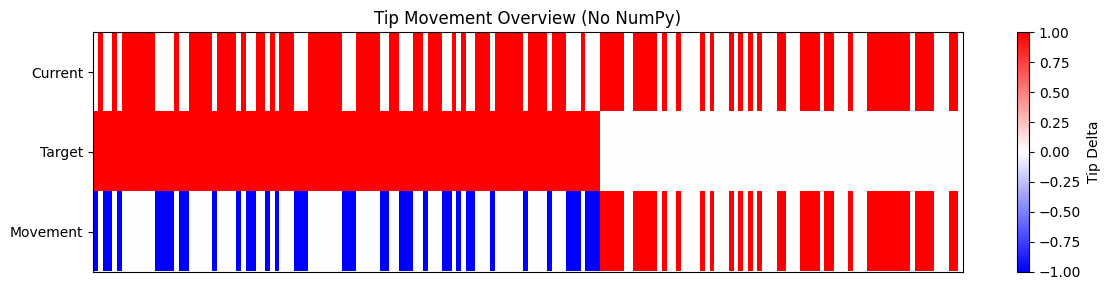

In [27]:
import random
import matplotlib.pyplot as plt

# Parameters
total_length = 182
num_tips = 106

# Generate current tip list
random.seed(42)
current_tips_list = [0] * total_length
for i in random.sample(range(total_length), num_tips):
    current_tips_list[i] = 1

# Generate target tip list
target_tips_list = [1 if i < num_tips else 0 for i in range(total_length)]

# Compute movement list
tip_movement_list = [
    c - t for c, t in zip(current_tips_list, target_tips_list)
]

# Stack lists for visualization
tips_matrix = [current_tips_list, target_tips_list, tip_movement_list]

# Convert to 2D list of floats for imshow
tips_matrix_float = [[float(x) for x in row] for row in tips_matrix]

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 3))
cax = ax.imshow(tips_matrix_float, cmap="bwr", aspect="auto", vmin=-1, vmax=1)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["Current", "Target", "Movement"])
ax.set_xticks([])
ax.set_title("Tip Movement Overview (No NumPy)")
plt.colorbar(cax, orientation='vertical', label='Tip Delta')
plt.tight_layout()
plt.show()


### 3.5- Cluster `add` by x-coordiate

In [28]:
from array import array

### 3.6- Merge `add` clusters if len(clusters) <= len(use_channels)

In [24]:
list(divide_list_into_chunks(
    [tipspot_x.has_tip() for tipspot_x in tip_rack.children],
    chunk_size=8
))

[[True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True]]

In [67]:
# Cell 1: Setup


# Optional: Install line_profiler in notebook (uncomment if not installed)
# !pip install line_profiler

# Load %lprun magic for line-by-line profiling
%load_ext line_profiler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 7.1 MB/s eta 0:00:00


In [68]:
# Cell 2: Define both functions for comparison

def use_numpy_randint(n=10):
    numbers = np.random.randint(0, 96, size=n)
    return numbers

def use_list_comprehension(n=10):
    numbers = [random.randint(0, 95) for _ in range(n)]
    return numbers


In [65]:
%%time
n = 10  # number of integers you want
numbers = np.random.randint(0, 96, size=n)
# print(numbers)

n = 10  # number of integers you want
numbers = [random.randint(0, 95) for _ in range(n)]


CPU times: user 267 µs, sys: 206 µs, total: 473 µs
Wall time: 437 µs


In [69]:
# Cell 3: Use timeit to compare overall execution time

print("Timing results (10000 runs):")

numpy_time = timeit.timeit("use_numpy_randint()", globals=globals(), number=10_000)
print(f"NumPy method: {numpy_time:.6f} seconds")

listcomp_time = timeit.timeit("use_list_comprehension()", globals=globals(), number=10_000)
print(f"List comprehension method: {listcomp_time:.6f} seconds")


Timing results (10000 runs):
NumPy method: 0.069364 seconds
List comprehension method: 0.049671 seconds


In [71]:
# Cell 4: Use line_profiler to analyze each function line by line

# Line-by-line profiling of list comprehension method
%lprun -f use_list_comprehension use_list_comprehension()

Timer unit: 1e-09 s

Total time: 5.2595e-05 s
File: /tmp/ipykernel_111796/2755184475.py
Function: use_list_comprehension at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def use_list_comprehension(n=10):
     8         1      52315.0  52315.0     99.5      numbers = [random.randint(0, 95) for _ in range(n)]
     9         1        280.0    280.0      0.5      return numbers

In [72]:

# Line-by-line profiling of NumPy method
%lprun -f use_numpy_randint use_numpy_randint()

Timer unit: 1e-09 s

Total time: 0.000164986 s
File: /tmp/ipykernel_111796/2755184475.py
Function: use_numpy_randint at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def use_numpy_randint(n=10):
     4         1     164734.0 164734.0     99.8      numbers = np.random.randint(0, 96, size=n)
     5         1        252.0    252.0      0.2      return numbers

In [25]:
[tipspot_x.tracker.remove_tip() for tipspot_x in tip_rack.children[:5]]

[None, None, None, None, None]

In [54]:
tip_rack_arr = np.array(tip_rack.children, dtype=object).reshape(12,8).T

has_tip_vectorized = np.vectorize(lambda obj: obj.name)

has_tip_vectorized(tip_rack_arr)

array([['tip rack_tipspot_0_0', 'tip rack_tipspot_1_0', 'tip rack_tipspot_2_0', 'tip rack_tipspot_3_0', 'tip rack_tipspot_4_0', 'tip rack_tipspot_5_0', 'tip rack_tipspot_6_0', 'tip rack_tipspot_7_0', 'tip rack_tipspot_8_0', 'tip rack_tipspot_9_0', 'tip rack_tipspot_10_0', 'tip rack_tipspot_11_0'],
       ['tip rack_tipspot_0_1', 'tip rack_tipspot_1_1', 'tip rack_tipspot_2_1', 'tip rack_tipspot_3_1', 'tip rack_tipspot_4_1', 'tip rack_tipspot_5_1', 'tip rack_tipspot_6_1', 'tip rack_tipspot_7_1', 'tip rack_tipspot_8_1', 'tip rack_tipspot_9_1', 'tip rack_tipspot_10_1', 'tip rack_tipspot_11_1'],
       ['tip rack_tipspot_0_2', 'tip rack_tipspot_1_2', 'tip rack_tipspot_2_2', 'tip rack_tipspot_3_2', 'tip rack_tipspot_4_2', 'tip rack_tipspot_5_2', 'tip rack_tipspot_6_2', 'tip rack_tipspot_7_2', 'tip rack_tipspot_8_2', 'tip rack_tipspot_9_2', 'tip rack_tipspot_10_2', 'tip rack_tipspot_11_2'],
       ['tip rack_tipspot_0_3', 'tip rack_tipspot_1_3', 'tip rack_tipspot_2_3', 'tip rack_tipspot_3_3',